# ZEV Mandate: Consultation Initial Thoughts and Reactions

This notebook explores some of the questions raised in the DfT's ZEV Mandate consultation, published in March 2023. 



In [248]:
# import packages
import pandas as pd
import numpy as np
%load_ext google.cloud.bigquery
import pickle
from matplotlib import pyplot as plt
with open('design.pkl','rb') as f:
    set_params = pickle.load(f)
plt.rcParams.update(set_params)

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


## Regional / National Question

insert code here to answer the question of whether one UK target should be required.

## Sample Car Company Calculation

In this section we will take an example of a car manufacturer and see how their sales in a twelve-month period would fare under the mandate with a made-up target. 

To change to a different manufacturer, simple change the name in the two SQL queries below. 

In [712]:
mandate = 0.16
credits = 0

zevm_compliance = False
co2_compliance = False


In [713]:
%%bigquery tg --project rugged-baton-283921
SELECT AVG(co2Emissions) as target
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND make IN ('HYUNDAI')
AND co2Emissions > 0
AND monthOfFirstRegistration >= '2021-01-01'
AND monthOfFirstRegistration < '2022-01-01'

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.02rows/s]


In [714]:
# The CO2 target is taken from the average Co2 rating of the non-ZEV sales from 2021. 
co2_target = tg.target[0]
co2_target

127.2359398193111

In [715]:
%%bigquery df --project rugged-baton-283921
SELECT registrationNumber, fuelType, co2Emissions, revenueWeight, 1 as num
FROM VES_dataset.VRN_UK
WHERE typeApproval = 'M1'
AND make IN ('HYUNDAI')
AND monthOfFirstRegistration >= '2022-03-01'
AND monthOfFirstRegistration < '2023-03-01'

Downloading: 100%|██████████| 77429/77429 [00:01<00:00, 39774.87rows/s]


In [716]:
# Total car sales is just the total number of vehicles in the dataframe. Each one starts with a quantifier - 1. 
total_car_sales = df.num.sum()
print("This manufacturer's total sales were {}.".format(total_car_sales))

# Now we calculate allowances under the ZEV mandate. 
allowances = (1-mandate) * total_car_sales
print("This manufacturer's total allowances were {}.".format(round(allowances)))

# Now we get the total non-ZEV sales
non_zev_sales = df[df.co2Emissions > 0].num.sum()
print("This manufacturer's total non-zev sales were {}.".format(non_zev_sales))

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

# UK new non-ZEV sales activity - credis >= allowances
if compliance > 0:
    print("This manufacturer is ZEV Mandate compliant with a surplus of {} allowances before flexibilities.".format(round(compliance)))
    
else:
    print("This manufacturer is ZEV Mandate non-compliant with a deficit of {} allowances before flexibilities. They will need to use flexibilities.".format(round(compliance)))

This manufacturer's total sales were 77429.
This manufacturer's total allowances were 65040.
This manufacturer's total non-zev sales were 64005.
This manufacturer is ZEV Mandate compliant with a surplus of 1035 allowances before flexibilities.


In [717]:
total_car_sales

77429

In [718]:
non_zev_sales

64005

In [719]:
# One flexibility comes from the CO2 regime. Let's see how they fare. 
activity = df.co2Emissions.sum()
co2_allowances = non_zev_sales * co2_target

if co2_allowances > activity:
    margin = co2_allowances - activity
    
    #paragraph 3.58 imposes 25% limit on transfers
    co2_zev_transfer_limit = (mandate * .25)*total_car_sales
    
    co2_zev_transfers = margin / 167
    if co2_zev_transfers < co2_zev_transfer_limit:
        pass
    else:
        co2_zev_transfers = co2_zev_transfer_limit
    
    print("This manufacturer has met their CO2 target, with {} CO2 allowances (not ZEV credits!) to spare.".format(round(margin)))
    print("This manufacturer has a spare {} ZEV credits resulting from their CO2 overperformance.".format(round(co2_zev_transfers)))
    
else:
    print("This manufacturer has a shortfall in their CO2 performance...!")

This manufacturer has met their CO2 target, with 177068 CO2 allowances (not ZEV credits!) to spare.
This manufacturer has a spare 1060 ZEV credits resulting from their CO2 overperformance.


In [720]:
# Can they achieve compliance after any available transfers from the CO2 regime?
credits += co2_zev_transfers

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

if compliance > 0:
    print("This manufacturer is compliant with a surplus of {} allowances before flexibilities.".format(round(compliance)))
else:
    print("This manufacturer is non-compliant with a deficit of {} allowances after taking into account the CO2 regime flexibilities.\nThey will need to use flexibilities.".format(round(compliance)))

This manufacturer is compliant with a surplus of 2096 allowances before flexibilities.


In [721]:
# One flexibility comes from borrowing. Borrowing allows manufacturers to borrow up to 75%, 50% or 25% in the first two years of the scheme. 
# We set the cap below:

borrowing_cap = .75

borrowable_allowances = (mandate * total_car_sales) * borrowing_cap

borrowable_allowances

9291.48

In [722]:
# Can they achieve compliance after any available transfers from the borrowing flexibility?

credits += borrowable_allowances

# Have they complied initially? The formula for compliance is as follows:
compliance = allowances - (non_zev_sales - credits)

if compliance > 0:
    print("This manufacturer is compliant with a surplus of {} allowances after borrowing.".format(round(compliance)))
else:
    print("This manufacturer is non-compliant with a deficit of {} allowances before flexibilities. They will need to use flexibilities.".format(round(compliance)))

This manufacturer is compliant with a surplus of 11387 allowances after borrowing.


In [723]:
total_car_sales

77429

In [724]:
manufacturer_names = 'Hyundai'

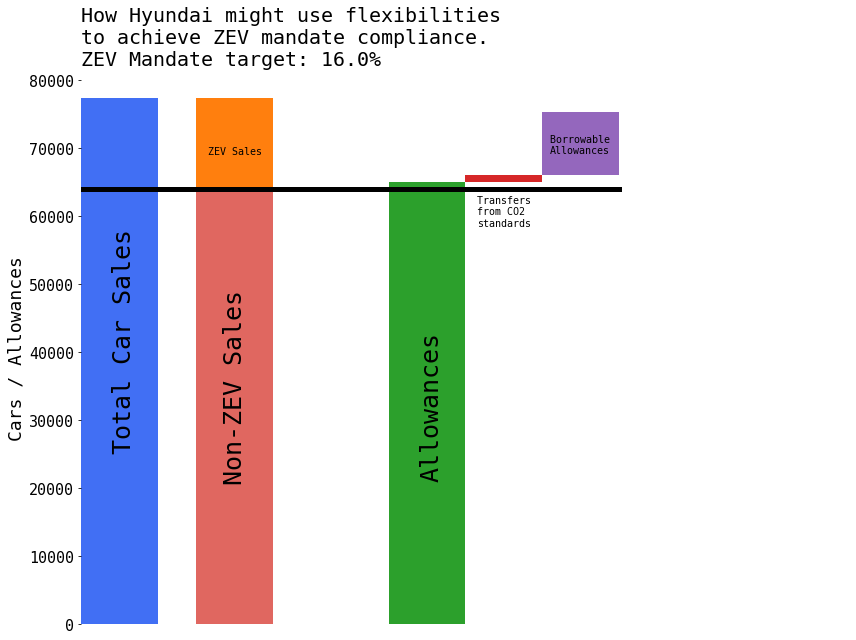

In [725]:
fig, ax = plt.subplots()

ax.set_title('How {m} might use flexibilities \nto achieve ZEV mandate compliance. \nZEV Mandate target: {t}%'.format(m=manufacturer_names, t=mandate*100), loc='left')

# ax.text(0, s='Assuming a ZEV Mandate target of {}%'.format(mandate*100), fontsize=15)
# ax.set_ylim(0, 150000)

ax.grid(False)
ax.set_xlim(0, 1)
ax.bar(.05, total_car_sales, width=0.1, label='Total Car Sales')
ax.axhline(y=non_zev_sales, xmin=0, xmax=.7, color='black', label='Required Allowances')
ax.bar(0.2, non_zev_sales, width=0.1, label='Non-ZEV Sales')
ax.bar(0.2, (total_car_sales - non_zev_sales), bottom=non_zev_sales, width=0.1, label='ZEV Sales', )
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylabel('Cars / Allowances')

# ax.bar(0.5, total_)
ax.bar(.45, allowances, width=0.1, label='Allowances')
ax.bar(.55, co2_zev_transfers, bottom=allowances, width=0.1, label='Credits from CO2 transfers')
ax.bar(.65, borrowable_allowances, bottom=(co2_zev_transfers + allowances), width=0.1, label='Credits from CO2 transfers', )

ax.text(.04, total_car_sales/3, s='Total Car Sales', fontsize=25, rotation='vertical')
ax.text(.185, non_zev_sales/3, s='Non-ZEV Sales', fontsize=25, rotation='vertical')
if total_car_sales > non_zev_sales:
    ax.text(.165, (non_zev_sales + (total_car_sales-non_zev_sales+2000)/3), s='ZEV Sales', fontsize=10, rotation='horizontal')
else:
    pass

ax.text(.44, allowances/3, s='Allowances', fontsize=25, rotation='vertical')
ax.text(.515, allowances - (allowances/10), s='Transfers \nfrom CO2 \nstandards', fontsize=10, rotation='horizontal')
ax.text(.61, (co2_zev_transfers + allowances+borrowable_allowances/3), s='Borrowable \nAllowances', fontsize=10, rotation='horizontal')


plt.savefig('plots/flexibilities_{}.png'.format(manufacturer_names), transparent=False, bbox_inches='tight', dpi=300)